# Прикладные задачи анализа данных

## Домашнее задание 4

В этой работе мы будем решать задачу рекомендаций музыки. Для этого мы реализуем метод коллаборативной фильтрации и модель со скрытыми переменными, сравним их между собой и попытаемся сделать выводы. Во всех заданиях разрешается переписывать код по своему усмотрению, предложенные шаблоны несут лишь рекомендательный характер.

In [1]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

In [2]:
# Подключение к Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Установка gdown для загрузки файлов с Google Drive
!pip install gdown

# Загрузка файлов с Google Drive по идентификаторам
!gdown --id 1OmDMl_hzPVKCfUESS_Mcn_oEYLdJQiS8 -O /content/tracks_info.csv
!gdown --id 13Q5LPnOQkWrKoNsXhmmyoh7-66p6SFKK -O /content/music_dataset.csv

Mounted at /content/drive
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1OmDMl_hzPVKCfUESS_Mcn_oEYLdJQiS8
To: /content/tracks_info.csv
100% 3.42M/3.42M [00:00<00:00, 22.2MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=13Q5LPnOQkWrKoNsXhmmyoh7-66p6SFKK
To: /content/music_dataset.csv
100% 1.32M/1.32M [00:00<00:00, 14.1MB/s]


In [3]:
ratings = pd.read_csv('music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [4]:
tracks_info = pd.read_csv('tracks_info.csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1 (1 балл).** Реализуйте метрику $MAP@k$.

In [5]:
def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):
    # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
    map_k, count = 0, 0
    for relevant_items, predicted_items in zip(relevant, predicted): # берем значение для item из предикт и из релевант
        if not relevant_items:
            continue
        # Для каждого юзера считаем AP@k и добавляем в сумму
        correct = np.isin(predicted_items[:k], relevant_items) # rel_i
        AP_k = (correct / np.arange(1, k + 1))
        non_zero_indices = np.nonzero(correct)[0] # Получим индексы не нулей
        order_numbers = np.arange(1, len(non_zero_indices) + 1) # создаем упорядоченный список до количества ненулей
        AP_k[non_zero_indices] *= order_numbers
        map_k += AP_k.sum() / min(k, len(relevant_items))
        count += 1
    # усредняем по всем юзерам
    map_k = map_k / count
    return map_k

In [6]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]

assert round(mapk(relevant, pred, k=5), 4) == 0.4331

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [6]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [7]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [8]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [9]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [10]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [11]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [12]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [13]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

**Задание 2 (1 балл).** Реализуйте метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [14]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1. # всем существующим парам юзер-айтем будет проставлена 1, у пар, которые не смэтчены друг с другом, стоит 0, то есть этот юзер не слушал этот трек

    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        scores = np.random.rand(self.n_items) # или любая другая модель, здесь просто предсказываем рандом, можно любой другой скор, более умный
        recommended_items = np.argsort(scores)[::-1]
        return recommended_items

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k] # Выбираем первые k элементов в векторе, которые не прослушаны пользователем

        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []

        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        # Для каждого юзера считаем рекомендации на основе модели и добавляем в test_preds. test_preds.shape = (n_users, n_items)
        for uid in np.unique(self.ratings['userId']):
            recommended_items = self.recommend(uid) # вектор длины n_items
            test_preds += [recommended_items]

        # Удаляем уже прослушанные треки из рекомендуемых
        # filtered_preds.shape = (n_users, k)
        filtered_preds = self.remove_train_items(test_preds, k)

        return filtered_preds

## Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать две метрики:

1. Корреляция Пирсона $$s(u, v) = \frac{\sum_{i \in I_u \cap I_v} r_{ui}r_{vi}}{\sqrt{\sum_{i \in I_u} r_{ui} ^2}\sqrt{\sum_{i \in I_v} r_{vi}^2}} $$

2. Мера Жаккара

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Корреляция Пирсона немного видоизменена, чтобы подходить под нашу задачу.


Во всех формулах
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.1 (1 балл).** Реализуйте функцию подсчета корреляции Пирсона.

**Задание 3.2 (1 балл).** Реализуйте функцию подсчета меры Жаккара.

Функции принимают матрицу оценок и вектор оценок пользователя $u$ и возвращают вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

In [15]:
def pearson(ratings: np.array, user_vector: np.array, alpha) -> np.array:
    # your code here: (￣▽￣)/♫•*¨*•.¸¸♪

    # учтем условие, что соседи все \ {u}
    mask = ~(ratings == user_vector).all(axis=1)
    rating_neighbours = ratings[mask]

    # числитель для similarity
    numerator = rating_neighbours.dot(user_vector)

    # куски знаменателя для similarity
    user_norm = np.sqrt(np.sum(user_vector ** 2))
    ratings_norms = np.sqrt(np.sum(rating_neighbours ** 2, axis=1))

    # чекаем, чтобы не было деления на ноль, если такое есть, то заменяем на ноль
    with np.errstate(divide='ignore', invalid='ignore'):
      similarity = numerator / (ratings_norms * user_norm)
      similarity[np.isnan(similarity)] = 0  # Заменяем NaN на 0

    # теперь посчитаем агрегированный показатель
    numerator = similarity[:, np.newaxis] * rating_neighbours
    # оставим только вектор, соответствующий similarity > alpha
    numerator = numerator[similarity > alpha].sum(axis = 0)
    denominator = similarity[similarity > alpha].sum()

    # чекаем снова, чтобы не было деления на ноль
    with np.errstate(divide='ignore', invalid='ignore'):
          r_ui = numerator / denominator
          r_ui = np.where(np.isnan(r_ui) | np.isinf(r_ui), 0, r_ui)

    return r_ui


def jaccard(ratings: np.array, user_vector: np.array, alpha) -> np.array:
    # your code here: (￣▽￣)/♫•*¨*•.¸¸♪

    # учтем условие, что соседи все \ {u}
    mask = ~(ratings == user_vector).all(axis=1)
    rating_neighbours = ratings[mask]

    intersection = rating_neighbours * user_vector
    union = ((rating_neighbours == 1) | (user_vector == 1)).astype(int)

    with np.errstate(divide='ignore', invalid='ignore'):
      similarity = intersection.sum(axis = 1) / union.sum(axis = 1)
      similarity[np.isnan(similarity)] = 0

    numerator = similarity[:, np.newaxis] * rating_neighbours

    # оставим только вектор, соответствующий similarity > alpha
    numerator = numerator[similarity > alpha].sum(axis = 0)
    denominator = similarity[similarity > alpha].sum()

    with np.errstate(divide='ignore', invalid='ignore'):
      r_ui = numerator / denominator
      r_ui = np.where(np.isnan(r_ui) | np.isinf(r_ui), 0, r_ui)
    return r_ui

Проверка работы:

In [17]:
rat = np.array([[1, 0, 1],
                [0, 1, 1],
                [1, 0, 0]

])

u_vec = np.array([1, 0, 1])

print(f"Пирсон: {np.round(pearson(rat, u_vec, alpha = 0.1), 4)}")
print(f"Жаккар: {np.round(jaccard(rat, u_vec, alpha = 0.1), 4)}")

Пирсон: [0.5858 0.4142 0.4142]
Жаккар: [0.6 0.4 0.4]


**Задание 4 (1 балл).** Реализуйте методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок.


In [16]:
class User2User(BaseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        assert similarity_func in [pearson, jaccard]

        self.similarity_func = similarity_func
        self.alpha = 0.02

    def similarity(self, user_vector: np.array, alpha):
        """
        user_vector: [n_items]
        """
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        # считаем сходство челика с другими челиками
        return self.similarity_func(self.R, user_vector, alpha = alpha)

    def recommend(self, uid: int):
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        user_vector = self.R[uid, :] # все айтемы юзера

        # Вычисляем сходства между текущим пользователем и всеми остальными
        predicted_ratings = self.similarity(user_vector, alpha = self.alpha) # получаем вектор r_ui, характеризующий сходство пользователя со всеми другими пользователями по конкретным айтемам

        if np.all(predicted_ratings == 0):
            return np.argsort(user_vector)[::-1]  # Если нет соседей, возвращаем треки пользователя, отсортированные по убыванию

        # Убираем уже прослушанные треки из рекомендаций
        predicted_ratings[user_vector > 0] = -np.inf

        # Возвращаем индексы треков, отсортированные по убыванию предсказанных оценок
        return np.argsort(predicted_ratings)[::-1]

**Задание 5 (1 балл).** Постройте графики зависимости значений $MAP@k$ от разных $k$ для обоих функций похожести, сравните их между собой, а также с предсказаниями случайного алгоритма и сделайте выводы.

Random model time: 3.8723 seconds
Pearson model time: 61.5171 seconds
Jaccard model time: 62.5917 seconds


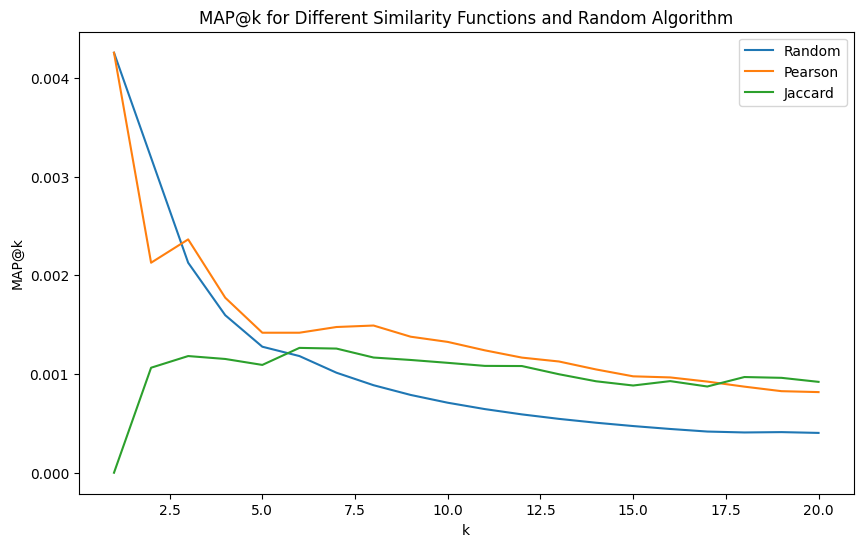

In [19]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪
import time

random_model = BaseModel(train_ratings)
pearson_model = User2User(train_ratings, pearson)
jaccard_model = User2User(train_ratings, jaccard)

k_values = range(1, 21)

# Замер времени выполнения для случайного алгоритма
start_time = time.time()
random_preds = random_model.get_test_recommendations(k=max(k_values))
random_time = time.time() - start_time

# Замер времени выполнения для алгоритма на основе корреляции Пирсона
start_time = time.time()
pearson_preds = pearson_model.get_test_recommendations(k=max(k_values))
pearson_time = time.time() - start_time

# Замер времени выполнения для алгоритма на основе коэффициента Жаккара
start_time = time.time()
jaccard_preds = jaccard_model.get_test_recommendations(k=max(k_values))
jaccard_time = time.time() - start_time

print(f"Random model time: {random_time:.4f} seconds")
print(f"Pearson model time: {pearson_time:.4f} seconds")
print(f"Jaccard model time: {jaccard_time:.4f} seconds")

# Рассчитаем MAP@k для разных k и построим графики
random_mapk = []
pearson_mapk = []
jaccard_mapk = []

for k in k_values:
    random_mapk.append(mapk(test_relevant, random_preds, k))
    pearson_mapk.append(mapk(test_relevant, pearson_preds, k))
    jaccard_mapk.append(mapk(test_relevant, jaccard_preds, k))

plt.figure(figsize=(10, 6))
plt.plot(k_values, random_mapk, label='Random')
plt.plot(k_values, pearson_mapk, label='Pearson')
plt.plot(k_values, jaccard_mapk, label='Jaccard')
plt.xlabel('k')
plt.ylabel('MAP@k')
plt.title('MAP@k for Different Similarity Functions and Random Algorithm')
plt.legend()
plt.show()

Видим, что наилучшей мерой сходства по MAP@k в среднем для любого k является коэффициент Пирсона, затем мера Жаккара и самой худшей является случайное предсказание. Это связано с особенностями функций похожести и особенностями задачи. Случайное предсказание наихудшее, потому что у нас много юзеров и айтемов и при рандомном предсказании юзер слушает нерелевантный с большой долей вероятности трек. Лучше всего как меру схожести использовать коэффициент Пирсона в данной задаче, он учитывает корреляцию между треками пользователей и потому является наилучшей мерой схожести в данной задаче.

**Задание 6 (1.5 балла).** Как вы могли заметить, матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишите код так, чтобы все методы могли работать с разреженными матрицами и сравните скорость работы такого подхода с оригинальным.

In [ ]:
# your code here: ‿︵‿︵ヽ(°□° )ノ︵‿︵‿

Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

In [21]:
user_id = np.random.randint(0, pearson_model.n_users)

In [23]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
55,A Little Faster,['There For Tomorrow']
2806,With You,['Linkin Park']
2809,Enth E Nd (Kutmasta Kurt Reanimation),"['Linkin Park', 'Motion Man']"
3117,In Between,['Linkin Park']
5082,Blood Sugar,['Pendulum']
5323,Heartkiller,['HIM']
5540,Hay Loft,['Mother Mother']
5709,Witchcraft,['Pendulum']
7274,Sad,['Pearl Jam']
8647,The Island,['Pendulum']


In [22]:
preds = pearson_model.get_test_recommendations(15)

print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

Predicted tracks:


,name,artists
23429,Stressed Out,['twenty one pilots']
29169,Heathens,['twenty one pilots']
24500,Way Down We Go,['KALEO']
42324,Go Fuck Yourself,['Two Feet']
35064,Thunder,['Imagine Dragons']
22325,Dancin,"['Aaron Smith', 'Krono', 'Luvli']"
6198,I Hate Everything About You,['Three Days Grace']
11950,Somebody That I Used To Know,"['Gotye', 'Kimbra']"
54885,Odium,"['LXST CXNTURY', 'Kingpin Skinny Pimp']"
57338,Kosandra,['Miyagi & Andy Panda']


In [24]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists
64502,Zuccenberg,"['Tommy Cash', '$uicideBoy$', 'Diplo']"
64808,Некуда бежать,"['Pyrokinesis', 'МУККА', 'BOOKER']"
64823,Wind,['Akeboshi']
64881,MADARA,"['FREE FLOW FLAVA', 'NKOHA']"
65199,Shy Away,['twenty one pilots']
65934,Revolver,['bülow']
66217,Disaster,['KSLV Noh']


Получилось все равно плохо, очень мало треков совпали с тестом, надо делать что-то лучше - матричную факторизацию.

### Часть 2. Модель со скрытыми переменными

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_u \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно.

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

**Задание 7 (1.5 балла).** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастческим градинтным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Выведите формулы обновления параметров для обоих методов.

**LFM**

Ответ

https://drive.google.com/file/d/1xQ6WonkEki55v1ue9YngQQ_lMbEzU3X6/view?usp=sharing

**ALS**

Ответ

https://drive.google.com/file/d/1S3z2aYNOO-pnhlOOG3laGP82dU056G_2/view?usp=drive_link

**Задание 8 (2 балла).** Реализуйте методы оптимизации параметров для обоих алгоритмов.

In [17]:
class HiddenVars(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd'):
        super().__init__(ratings)
        self.dim = dim

        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))

        self.lr = 0.0003
        self.lamb = 0.01

    def fit(self, num_iters=5):
        for epoch in tqdm(range(num_iters)):

            if self.mode == 'sgd':
                # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
                for u in range(self.n_users):
                    for i in range(self.n_items):
                        r_ui = self.R[u, i]
                        error = r_ui - np.dot(self.P[u], self.Q[i])
                        self.P[u] -= self.lr * (error * self.Q[i] + self.lamb * self.P[u])
                        self.Q[i] -= self.lr * (error * self.P[u] + self.lamb * self.Q[i])

            elif self.mode == 'als':
                for u in range(self.n_users):
                    idx = self.ratings[self.ratings['userId'] == u].index
                    if len(idx) == 0:
                        continue
                    R_u = np.ones(len(idx))
                    Q_u = self.Q[self.ratings.loc[idx, 'trackId'].values]
                    self.P[u] = np.linalg.solve(Q_u.T @ Q_u + self.lamb * np.eye(self.dim), Q_u.T @ R_u)

                for i in range(self.n_items):
                    idx = self.ratings[self.ratings['trackId'] == i].index
                    if len(idx) == 0:
                        continue
                    R_i = np.ones(len(idx))
                    P_i = self.P[self.ratings.loc[idx, 'userId'].values]
                    self.Q[i] = np.linalg.solve(P_i.T @ P_i + self.lamb * np.eye(self.dim), P_i.T @ R_i)


    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T

        return np.argsort(pred_rating)[::-1]

**Задание 9 (1 балл).** Для обоих алгоритмов подберите оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Как изменяется качество предсказаний с числом итераций обучения? Постройте соответствующие графики, сравните со случайным подхом и User2User, сделайте выводы. Какой алгоритм вам кажется более подходящим для данной задачи и почему?

P.S. Хотя бы один из методов обучения должен приводить к лучшим результатам в сравнении с User2User подходом.

P.P.S. Методу LFM свойственно переобучаться, поэтому при подборе параметров полезно смотреть на значения ошибки и оптимизируемой метрики на тренировочном датасете. Вы также можете менять начальную инициализацию и прочие параметры, за исключением архитектуры, на ваш вкус.

  0%|          | 0/1 [00:00<?, ?it/s]

<ipython-input-26-1b2bb5c271b6>:25: RuntimeWarning: overflow encountered in multiply
  self.Q[i] -= self.lr * (error * self.P[u] + self.lamb * self.Q[i])
<ipython-input-26-1b2bb5c271b6>:24: RuntimeWarning: overflow encountered in multiply
  self.P[u] -= self.lr * (error * self.Q[i] + self.lamb * self.P[u])
<ipython-input-26-1b2bb5c271b6>:24: RuntimeWarning: invalid value encountered in add
  self.P[u] -= self.lr * (error * self.Q[i] + self.lamb * self.P[u])
<ipython-input-26-1b2bb5c271b6>:46: RuntimeWarning: invalid value encountered in matmul
  pred_rating = self.P[uid] @ self.Q.T


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

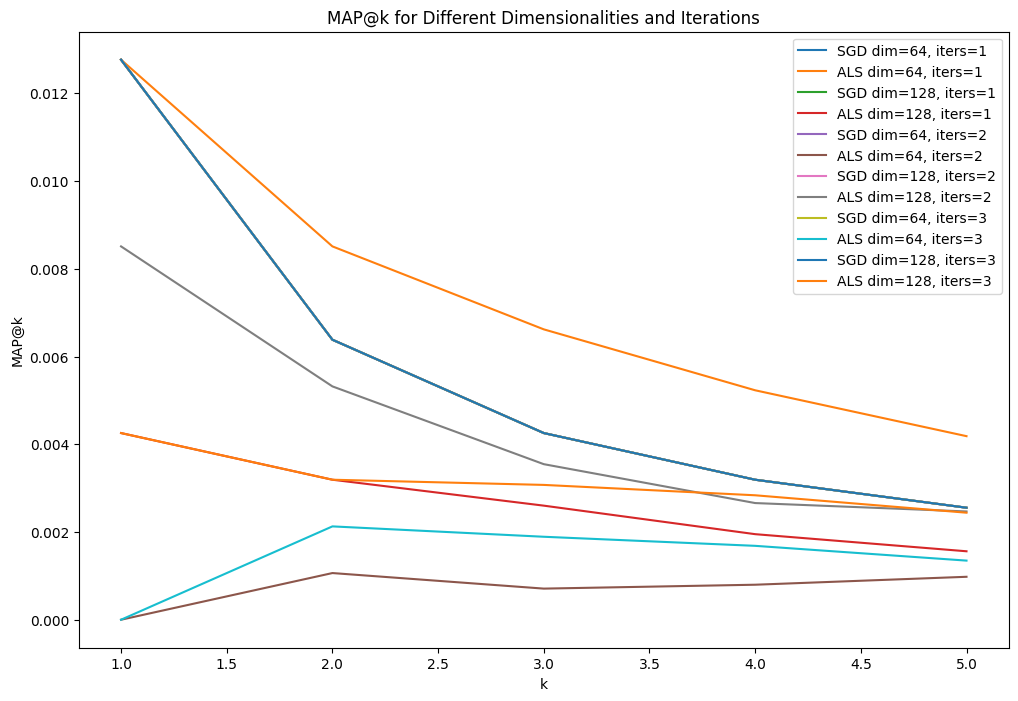

In [32]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪
NUM_ITERS = [1, 2, 3]
DIMS = [64, 128]
k_values = np.arange(1, 6)

plt.figure(figsize=(12, 8))

for num_iters in NUM_ITERS:
    for dim in DIMS:
        sgd_model = HiddenVars(train_ratings, dim=dim, mode="sgd")
        sgd_model.fit(num_iters=num_iters)
        sgd_preds = sgd_model.get_test_recommendations(k=max(k_values))

        als_model = HiddenVars(train_ratings, dim=dim, mode="als")
        als_model.fit(num_iters=num_iters)
        als_preds = als_model.get_test_recommendations(k=max(k_values))

        sgd_mapk = []
        als_mapk = []

        for k in k_values:
            sgd_mapk.append(mapk(test_relevant, sgd_preds, k))
            als_mapk.append(mapk(test_relevant, als_preds, k))

        plt.plot(k_values, sgd_mapk, label=f'SGD dim={dim}, iters={num_iters}')
        plt.plot(k_values, als_mapk, label=f'ALS dim={dim}, iters={num_iters}')

plt.xlabel('k')
plt.ylabel('MAP@k')
plt.title('MAP@k for Different Dimensionalities and Iterations')
plt.legend()
plt.show()

Наилучшая модель получилась ALS с параметрами dim = 128, n_iters = 3, оптимальное число предсказаний k для наивысшей точности - это предсказание 1 наилучшего трека, но также можно предсказывать и 2 наилучших трека для рекомендации.

Наилучшие параметры для ALS dim = 128, n_iters = 3, k = 1

Наилучшие параметры для SGD dim = 128, n_iters = 3, k = 1

В целом видим такую тенденцию: при росте числа итераций при обучении становится лучше MAP@k, также лучше при росте размерности d матриц факторизации.

Данные подходы обеспечивают лучшее качество по сравнению с User-2-User подходом и с рандомным подходом. Матричная факторизация при правильном подборе гиперпараметров показывает лучшие результаты, чем просто User-2-User подход, однако его коэффициенты сложнее интерпретировать.

Наиболее подходящим для данной задачи является именно подход с матричной факторизацией, а именно ALS. Размерность эмбеддинга d для обучения позволяет находить более сложные закономерности, чем просто анализ сходства эмбедингов юзеров или айтемов. Хоть его и сложнее интерпретировать, но он показывает лучшие результаты. ALS позволяет нам по очереди обучать по отдельности матрицы P и Q, что также на практике является более эффективным, чем просто SGD - SGD считается по 1 объекту, поэтому дисперсия производной является высокой, что делает наш прогноз шумным, возможно, стоит попробовать mini-batch SGD и станет лучше, но сам SGD очень шумный получается и поэтому качество хуже ALS, но все же лучше, чем у подхода User-2-User

Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [18]:
als_model = HiddenVars(train_ratings, dim=128, mode="als")
als_model.fit(num_iters=3)

  0%|          | 0/3 [00:00<?, ?it/s]

In [19]:
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = als_model.Q @ als_model.Q[example_trackId]
preds = preds / np.sqrt((als_model.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [20]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(als_model.Q[example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
2058,Последний герой,['КИНО'],0.736009
5570,Моё сердце,['Сплин'],0.612498
39732,"Another Brick In The Wall, Pt. 2",['Pink Floyd'],0.612466
26075,Лошадка,['Найк Борзов'],0.603792
19430,Вечная молодость,['Чиж & Co'],0.603027
16637,Zodiac,['Zodiac'],0.593939
5153,Stormbringer,['Deep Purple'],0.593939
9689,Bicycle Race,['Queen'],0.593939
9449,Это всё…,['ДДТ'],0.576523
